# Field Validation

In [31]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [43]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')

In [44]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape
#Reshape data for LSTM (add time step dimension)
test_data_scaled_normal = test_data_scaled_normal.values.reshape(test_data_scaled_normal.shape[0], 1, test_data_scaled_normal.shape[1])
test_data_scaled_abnormal = test_data_scaled_abnormal.values.reshape(test_data_scaled_abnormal.shape[0], 1, test_data_scaled_abnormal.shape[1])
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape


((2456, 1, 100), (230, 1, 100))

In [45]:
# Make predictions using lstm utoencoder
lstm = tf.keras.models.load_model('../../models/lstm_autoencoder_best.keras')
with open('../../models/lstm_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


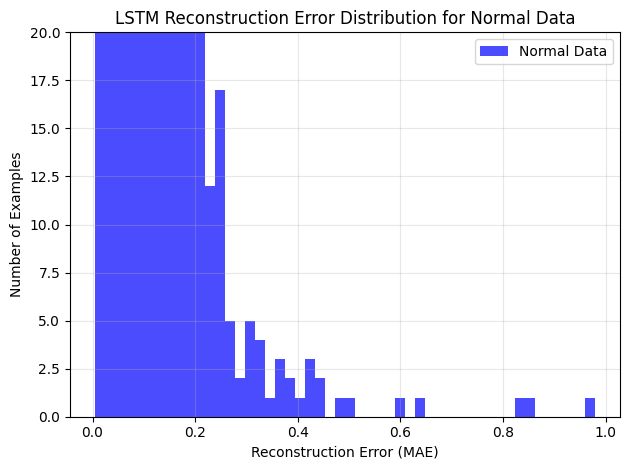

In [51]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = lstm.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.hist(train_loss_normal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Normal Data')

plt.title('LSTM Reconstruction Error Distribution for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0,20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


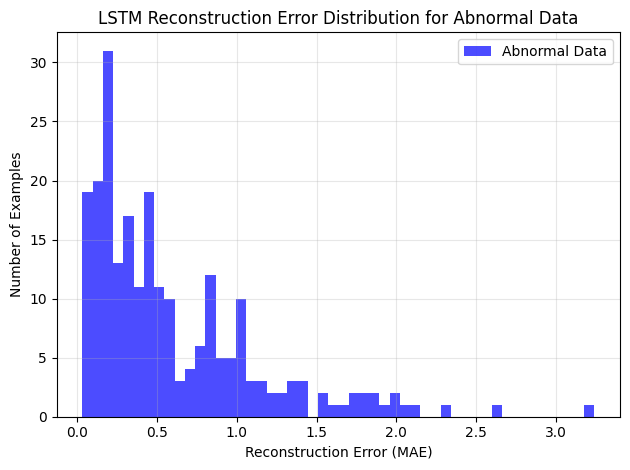

Mean reconstruction error: 0.0332
Median reconstruction error: 0.4334
Standard deviation: 0.5350


In [52]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = lstm.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Abnormal Data')

plt.title('LSTM Reconstruction Error Distribution for Abnormal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean reconstruction error: {np.min(train_loss_abnormal):.4f}")
print(f"Median reconstruction error: {np.median(train_loss_abnormal):.4f}")
print(f"Standard deviation: {np.std(train_loss_abnormal):.4f}")

In [ ]:
# # Find indices where reconstruction error is less than 0.5
# low_reconstruction_indices = np.where(train_loss_abnormal < 0.2)[0]

# # Get the indices of abnormal samples in the original dataframe
# abnormal_mask = df['curb_scene'] == 1
# abnormal_indices = df[abnormal_mask].index

# # Map the indices from abnormal subset to original dataframe indices
# original_indices = abnormal_indices[low_reconstruction_indices]

# print("\nCorresponding indices in original dataframe:")
# print(original_indices)



Corresponding indices in original dataframe:
Index([ 131,  132,  133,  240,  280,  520,  521,  687,  887,  888,  889,  891,
        993, 1066, 1164, 1172, 1270, 1271, 1272, 1273, 1348, 1415, 1416, 1492,
       1493, 1494, 1495, 1635, 1748, 1916, 1931, 2214, 2224, 2301, 2382, 2391,
       2392, 2397, 2399, 2410, 2417, 2419, 2420, 2422, 2427, 2429, 2461, 2464,
       2466, 2473, 2481, 2491, 2494, 2496, 2506, 2604],
      dtype='int64')


In [ ]:
# # Add the loss values back to the original DataFrame
# df.loc[df['curb_scene'] == 0, 'loss'] = train_loss_normal.numpy()
# df.loc[df['curb_scene'] == 1, 'loss'] = train_loss_abnormal.numpy()

In [ ]:
#df.iloc[2604, df.columns.get_loc('curb_scene')] = 0

In [ ]:
# # Alternatively, for better notebook display:
# df_selected = df[['curb_scene', 'start_time', 'loss']]
# df_selected.iloc[2604-5:2604+10]

,curb_scene,start_time,loss
2599,0,2025-03-28 16:22:18.599,0.082150
2600,0,2025-03-28 16:22:19.096,0.195205
2601,0,2025-03-28 16:22:19.591,0.220205
2602,0,2025-03-28 16:22:20.201,0.111258
2603,0,2025-03-28 16:22:20.698,0.168992
2604,0,2025-03-28 16:22:21.194,0.169743
2605,1,2025-03-28 16:22:22.089,0.381934
2606,1,2025-03-28 16:22:22.586,0.872487
2607,1,2025-03-28 16:22:23.082,0.346295
2608,0,2025-03-28 16:22:23.578,0.366118



--- Using Low Threshold: 0.200000 ---


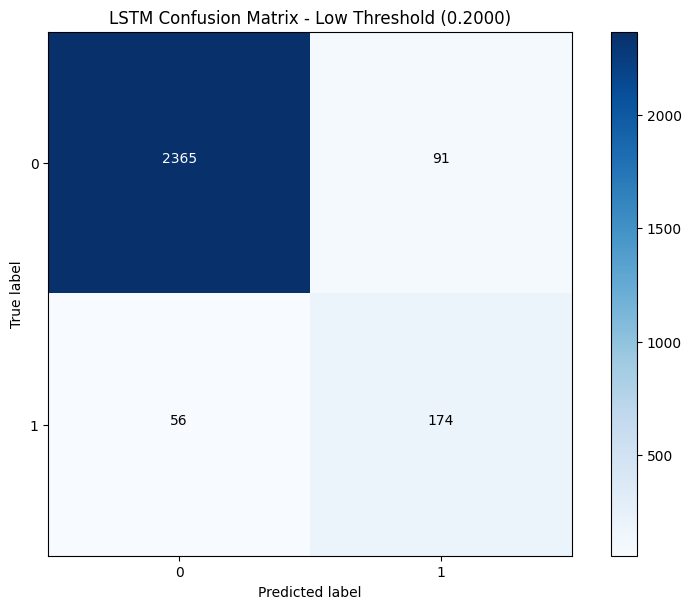


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2456
           1       0.66      0.76      0.70       230

    accuracy                           0.95      2686
   macro avg       0.82      0.86      0.84      2686
weighted avg       0.95      0.95      0.95      2686

Accuracy: 0.9453
Precision: 0.6566
Recall: 0.7565
F1 Score: 0.7030

--- Using Middle Threshold: 0.376742 ---


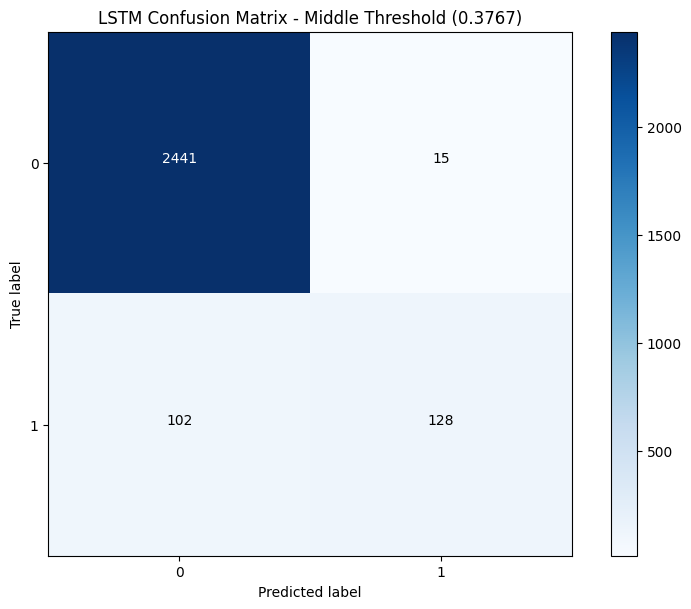


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2456
           1       0.90      0.56      0.69       230

    accuracy                           0.96      2686
   macro avg       0.93      0.78      0.83      2686
weighted avg       0.95      0.96      0.95      2686

Accuracy: 0.9564
Precision: 0.8951
Recall: 0.5565
F1 Score: 0.6863

--- Using High Threshold: 0.691475 ---


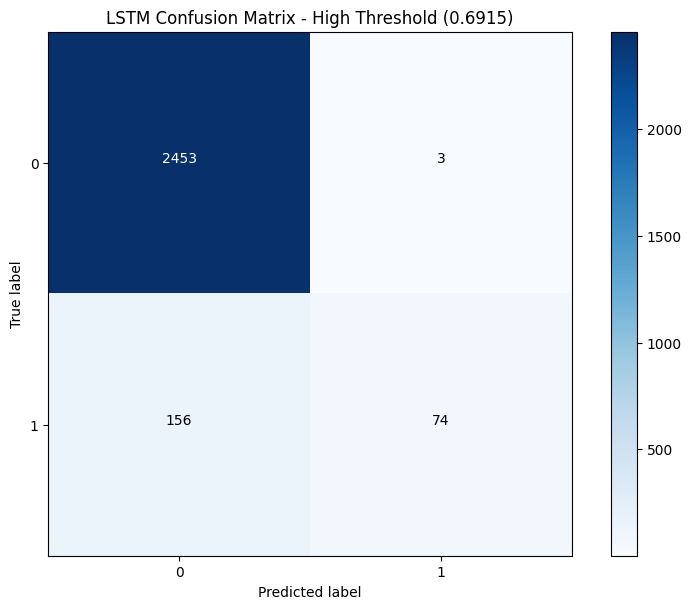


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2456
           1       0.96      0.32      0.48       230

    accuracy                           0.94      2686
   macro avg       0.95      0.66      0.73      2686
weighted avg       0.94      0.94      0.93      2686

Accuracy: 0.9408
Precision: 0.9610
Recall: 0.3217
F1 Score: 0.4821

--- Threshold Comparison ---
Threshold       Value      Accuracy   Precision  Recall     F1 Score  
-----------------------------------------------------------------
low             0.2000     0.9453     0.6566     0.7565     0.7030    
middle          0.3767     0.9564     0.8951     0.5565     0.6863    
high            0.6915     0.9408     0.9610     0.3217     0.4821    


In [ ]:
# Function to create and display confusion matrix for a given threshold
def create_confusion_matrix(threshold, threshold_name):
    print(f"\n--- Using {threshold_name}: {threshold:.6f} ---")
    
    # Prepare the true labels and predictions
    true_labels = []
    predictions = []
    
    # Normal data (label 0)
    # Flatten the MAE values since LSTM outputs have an extra dimension
    normal_predictions = (train_loss_normal.numpy().flatten() > threshold).astype(int)
    true_labels.extend([0] * len(normal_predictions))
    predictions.extend(normal_predictions)
    
    # Abnormal data (label 1)
    abnormal_predictions = (train_loss_abnormal.numpy().flatten() > threshold).astype(int)
    true_labels.extend([1] * len(abnormal_predictions))
    predictions.extend(abnormal_predictions)
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Label the plot
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=classes))
    
    # Calculate and display metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }

# Generate confusion matrices for all thresholds
results = {}

# Check which threshold keys are available in your JSON
if 'low_threshold' in loaded_thresholds:
    results['low'] = create_confusion_matrix(loaded_thresholds['low_threshold'], 'Low Threshold')
    
if 'middle_threshold' in loaded_thresholds:
    results['middle'] = create_confusion_matrix(loaded_thresholds['middle_threshold'], 'Middle Threshold')
    
if 'high_threshold' in loaded_thresholds:
    results['high'] = create_confusion_matrix(loaded_thresholds['high_threshold'], 'High Threshold')

# Compare the results
print("\n--- Threshold Comparison ---")
print(f"{'Threshold':<15} {'Value':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 65)
for name, result in results.items():
    print(f"{name:<15} {result['threshold']:<10.4f} {result['accuracy']:<10.4f} {result['precision']:<10.4f} {result['recall']:<10.4f} {result['f1']:<10.4f}")